In [ ]:
using ReinforcementLearningCore, RLIntro, RLIntro.Maze

using Plots, StatsBase

┌ Info: Precompiling ReinforcementLearningCore [de1b191a-4ae0-4afa-a27b-92d07f46b2d6]
└ @ Base loading.jl:1273


In [2]:
env = MazeEnv()
ns = length(get_observation_space(env))
na = length(get_action_space(env))

4

In [15]:
function plan_step(n)
    agent = DynaAgent(
        policy=QBasedPolicy(
            learner=TDLearner(
                approximator=TabularApproximator(n_state=ns, n_action=na),
                γ=0.1,
                optimizer=Descent(0.1),
                method=:SARS
                ),
            explorer=EpsilonGreedyExplorer(0.1)
            ),
        model=ExperienceBasedSampleModel(),
        trajectory=EpisodicCompactSARTSATrajectory(),
        plan_step=n
    )

    hook = StepsPerEpisode()
    run(agent, env, StopAfterEpisode(50),hook)
    hook.steps
end

plan_step (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


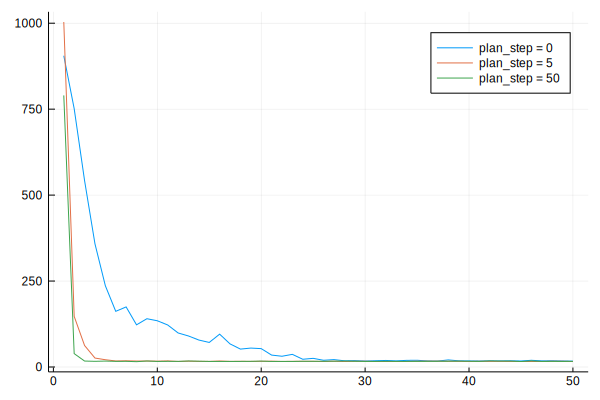

In [20]:
p = plot(legend=:topright)
for n in [0, 5, 50]
    plot!(p, mean(plan_step(n) for _ in 1:30), label="plan_step = $n")
end
p

In [25]:
function cumulative_dyna_reward(model, walls, nstep1, change, nstep2)
    env = MazeEnv(walls,
                  CartesianIndex(6, 4),
                  CartesianIndex(6, 4),
                  CartesianIndex(1, 9),
                  6,
                  9)
    ns = length(get_observation_space(env))
    na = length(get_action_space(env))
    agent = DynaAgent(
        policy=QBasedPolicy(
            learner=TDLearner(
                approximator=TabularApproximator(n_state=ns, n_action=na),
                γ=0.95,
                optimizer=Descent(1.),  # note that here we need to set alpha to 1.0 to get the result on the book
                method=:SARS
                ),
            explorer=EpsilonGreedyExplorer(0.1)
            ),
        model=model,
        trajectory=EpisodicCompactSARTSATrajectory(),
        plan_step=10
    )
    
    # hook = ComposedHook(CumulativeReward(), StepsPerEpisode(), TotalRewardPerEpisode())
    hook = CumulativeReward()
    run(agent, env, StopAfterStep(nstep1;is_show_progress=false),hook)
    change(env.walls)
    run(agent, env, StopAfterStep(nstep2;is_show_progress=false),hook)
    hook.rewards
end

cumulative_dyna_reward (generic function with 1 method)

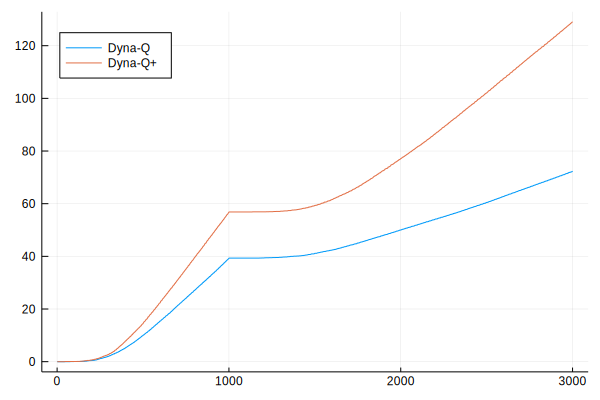

In [27]:
walls() = Set([CartesianIndex(4, j) for j in 1:8])
function change_walls(walls)
    pop!(walls, CartesianIndex(4,1))
    push!(walls, CartesianIndex(4,9))
end
plot(legend=:topleft)
plot!(mean(cumulative_dyna_reward(ExperienceBasedSampleModel(), walls(), 1000, change_walls, 2000) for _ in 1:30), label="Dyna-Q")
plot!(mean(cumulative_dyna_reward(TimeBasedSampleModel(4), walls(), 1000, change_walls, 2000) for _ in 1:30), label="Dyna-Q+")

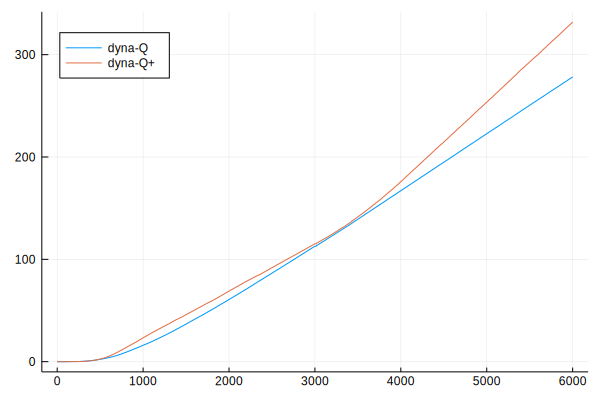

In [28]:
walls() = Set([CartesianIndex(4, j) for j in 2:9])
function change_walls(walls)
    pop!(walls, CartesianIndex(4,9))
end

p = plot(legend=:topleft)
plot!(p, mean(cumulative_dyna_reward(ExperienceBasedSampleModel(), walls(), 3000, change_walls, 3000) for _ in 1:50), label="dyna-Q")
plot!(p, mean(cumulative_dyna_reward(TimeBasedSampleModel(4, 1e-3), walls(), 3000, change_walls, 3000) for _ in 1:50), label="dyna-Q+")
p

In [2]:
function run_once(model, ratio=1)
    env = MazeEnv() * ratio
    ns = length(get_observation_space(env))
    na = length(get_action_space(env))
    agent = DynaAgent(
        policy=QBasedPolicy(
            learner=TDLearner(
                approximator=TabularApproximator(n_state=ns, n_action=na),
                γ=0.95,
                optimizer=Descent(0.5),
                method=:SARS
                ),
            explorer=EpsilonGreedyExplorer(0.1)
            ),
        model=model,
        trajectory=EpisodicCompactSARTSATrajectory(),
        plan_step=5
    )
    hook = StepsPerEpisode()
    run(agent, env, (args...) -> length(hook.steps) > 0 && hook.steps[end] <= 14 * ratio * 1.2,hook)
    model.sample_count
end

run_once (generic function with 2 methods)

In [6]:
p = plot(legend=:topleft)
plot!(mean([run_once(ExperienceBasedSampleModel(), ratio) for ratio in 1:6] for _ in 1:5), label="Dyna", yscale=:log10)
plot!(mean([run_once(PrioritizedSweepingSampleModel(), ratio) for ratio in 1:6] for _ in 1:5), label="Prioritized", yscale=:log10)
p

MethodError: MethodError: no method matching get_priority(::QBasedPolicy{TDLearner{TabularApproximator{2,Array{Float64,2}},:SARS,Descent},EpsilonGreedyExplorer{:linear,Random.MersenneTwister}}, ::Tuple{Int64,Int64,Float32,Bool,Int64})
Closest candidates are:
  get_priority(!Matched::TDLearner{#s19,:SARS,O} where O where #s19<:AbstractApproximator, ::Tuple) at /mnt/E4E0A9C0E0A998F6/github/ReinforcementLearningAnIntroduction.jl/src/extensions/learners/temporal_difference_learner.jl:245